<a href="https://colab.research.google.com/github/Chigaga/Dimimmings/blob/master/attempts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
from keras import Model, Input
from keras.layers import LSTM, TimeDistributed, Dense, Reshape, GaussianDropout, GaussianNoise
from keras.optimizers import Adam, RMSprop
from keras import backend as K
from keras.losses import MSE, MAE
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import regularizers

from matplotlib import pyplot as plt
from datetime import datetime
from datetime import timedelta
from keras import models

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

from pathlib import Path
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math

from pathlib import Path


Column 1 - year, yyyy

Column 2 - month, mm

Column 3 - day, dd

Column 4 - hour, hh

Column 5 - area of CH pixels in a meridional slice of width [-7.5 deg, 7.5 deg]. Not corrected for projection effects.

Column 6 - solar wind speed, km/s

Column 7 - IMF Magnitude Avg, nT

Column 8 - proton Density, n/cc

Column 9 - latitude of center of mass of all CH pixels in the meridional slice, given in %R_sun (lat[deg] = asin(lat) /pi*180)]. Not corrected for projection effects.

Column 10 - mean magnetic field density derived from all CH pixels in the meridional slice. Not corrected for any projection effects! (systematical errors can be significant!)

Column 11 - Percentage unbalanced magnetic flux derived from all CH pixels in the meridional slice; = sum(Phi_pixel) / sum(abs(Phi_pixel)). Not corrected for any projection effects! (systematical errors can be significant!).


In [4]:
folder = Path('/content/drive/My Drive/CH&SW')
file = folder / 'norm_smooth_60.txt'


df = pd.read_csv(file, delimiter=' ', header=None)
df.columns = ['year','month', 'day', 'hour', 'area', 'solar_wind', 'imf', 'p_density', 'lat_60', 'B_60', 'Phi_perun_60']
df = df.dropna()
df = df.drop(index = [0,1,2,3,4,5,6,7,8,9,10], axis=0)
df

,year,month,day,hour,area,solar_wind,imf,p_density,lat_60,B_60,Phi_perun_60
11,2010,10,1,12,0.030147,0.312738,0.071210,0.045767,0.063291,0.597328,0.713883
12,2010,10,1,13,0.024099,0.309457,0.069620,0.044141,0.065511,0.587770,0.693851
13,2010,10,1,14,0.019755,0.304995,0.066813,0.043886,0.069661,0.573686,0.663571
14,2010,10,1,15,0.015908,0.301877,0.064299,0.043058,0.074542,0.559106,0.623729
15,2010,10,1,16,0.012953,0.299271,0.062159,0.042561,0.079620,0.544882,0.577460
...,...,...,...,...,...,...,...,...,...,...,...
61955,2017,12,31,19,0.000839,0.301331,0.137675,0.287478,0.958107,0.524353,0.514809
61956,2017,12,31,20,0.000781,0.305411,0.177168,0.246410,0.974418,0.521004,0.503715
61957,2017,12,31,21,0.000747,0.306487,0.206481,0.207293,0.983908,0.519285,0.499723
61958,2017,12,31,22,0.000729,0.307819,0.220635,0.183746,0.989106,0.518934,0.502358


In [5]:
raw_time = np.array([datetime(y,m,d,h) for y,m,d,h in zip(df.year, df.month, df.day, df.hour)])         
raw_solar_wind = df.solar_wind.to_numpy()
raw_coronal_hole_area = df.area.to_numpy()
raw_latitude = df.lat_60.to_numpy()

In [6]:
#I dont use
full_time = [np.min(raw_time) + timedelta(hours=i) for i in range((np.max(raw_time) - np.min(raw_time))//timedelta(hours=1))]

full_time_float = [d.timestamp() for d in full_time]
time_float = [d.timestamp() for d in raw_time]

full_solar_wind = np.interp(full_time_float, time_float, raw_solar_wind)
full_coronal_hole_area = np.interp(full_time_float, time_float, raw_coronal_hole_area)
full_latitude = np.interp(full_time_float, time_float, raw_latitude)

print(len(raw_time), len(full_time))

61949 63563


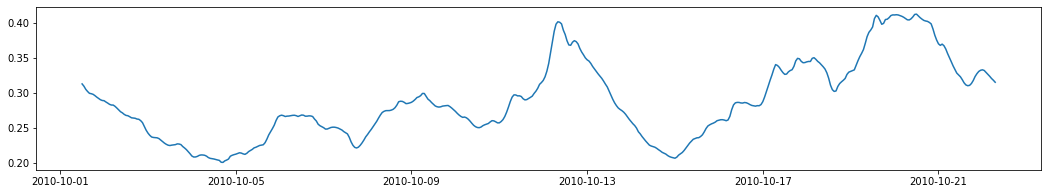

In [7]:
#wtf is full_solar_wind? I will use just raw one without this weird beginning
plt.figure(figsize=(18, 3))
plt.plot(full_time[:500], full_solar_wind[:500])

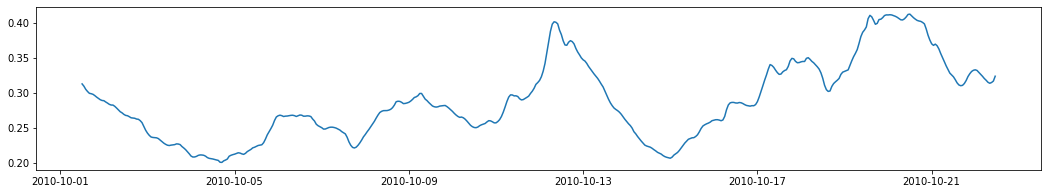

In [8]:
plt.figure(figsize=(18, 3))
plt.plot(raw_time[:500], raw_solar_wind[:500])

In [11]:
# Rebin - I NOT rebin
seq_len = 4
seq_len_out = 4

coronal_hole_area = full_coronal_hole_area[:-(len(full_coronal_hole_area)%24)].reshape((-1, 24)).mean(axis=1)
solar_wind = full_solar_wind[:-(len(full_solar_wind)%24)].reshape((-1, 24)).mean(axis=1)
latitude = full_latitude[:-(len(full_latitude)%24)].reshape((-1, 24)).mean(axis=1)
time = np.array(full_time)[:-(len(full_time)%24)].reshape((-1, 24))[:, 12]

Text(0.5, 1.0, 'Rebinning Comparison')

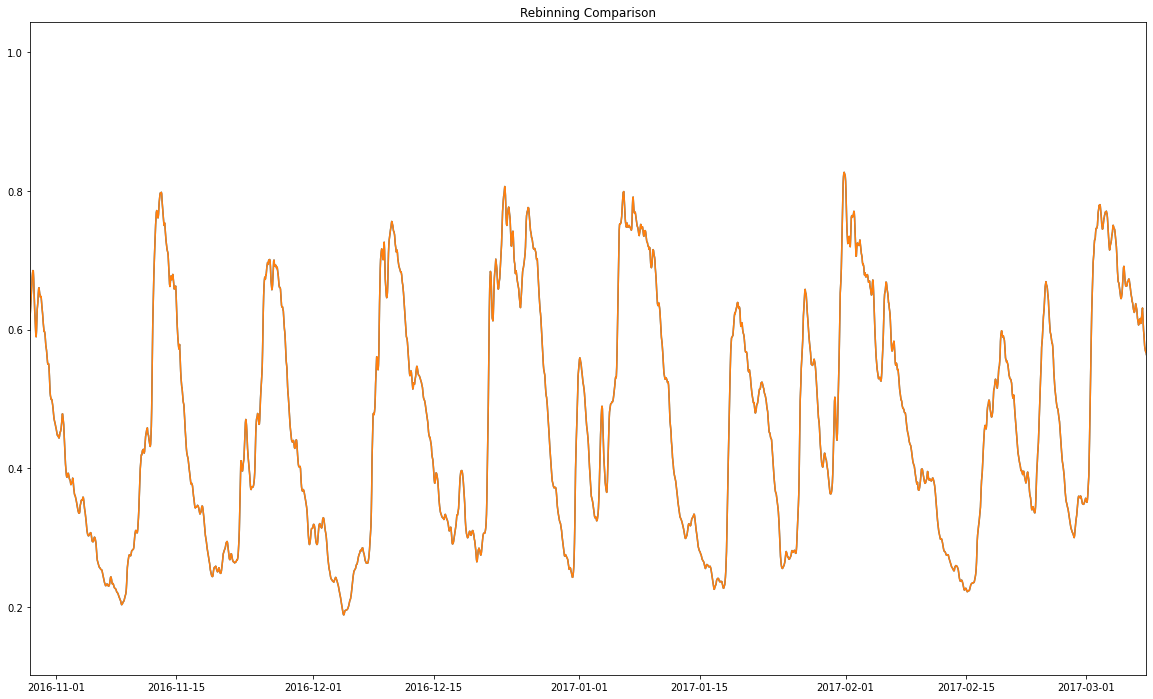

In [12]:
plt.figure(figsize=(20, 12))
plt.plot(raw_time, raw_solar_wind)
plt.plot(full_time,full_solar_wind)
#plt.plot(raw_time,raw_solar_wind)
plt.xlim(datetime(2016,10,29), datetime(2017,3,8))
plt.title('Rebinning Comparison')

In [ ]:
coronal_hole_area = (coronal_hole_area - np.min(coronal_hole_area)) / (np.max(coronal_hole_area) - np.min(coronal_hole_area)) * 2 - 1

solar_wind = (solar_wind - np.min(solar_wind)) / (np.max(solar_wind) - np.min(solar_wind)) * 2 - 1

latitude = (latitude - np.min(latitude)) / (np.max(latitude) - np.min(latitude)) * 2 - 1

#Prepare Dataset

In [13]:
seq_len = 96
seq_len_out = 96

x_ch = raw_coronal_hole_area[:-seq_len_out]
x_sw = raw_solar_wind[:-seq_len_out]
x_la = raw_latitude[:-seq_len_out]
time = raw_time[:-seq_len_out]
y_sw = raw_solar_wind[seq_len_out:]

In [ ]:
#dont use
x_ch = coronal_hole_area[:-seq_len_out]
x_sw = solar_wind[:-seq_len_out]
x_la = latitude[:-seq_len_out]
time = time[:-seq_len_out]
y_sw = solar_wind[seq_len_out:]

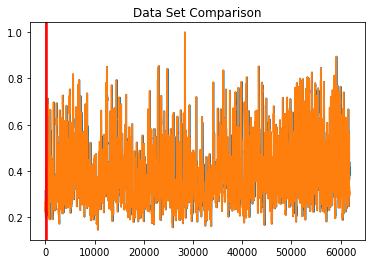

In [15]:
plt.plot(x_sw)
plt.plot(y_sw)
#plt.xlim(0,500)
plt.title('Data Set Comparison')
plt.axvline(seq_len, color='red')
plt.axvline(seq_len * 2, color='red')
plt.axvline(seq_len * 3, color='red')

In [60]:
#dont use
step = 1

x_data = np.array([np.stack((x_sw[i:i+seq_len], x_ch[i:i+seq_len], x_la[i:i+seq_len]), -1) 
                   for i in range(0, len(x_ch) - seq_len, step)])
y_data = np.array([y_sw[i:i+seq_len_out] for i in range(0, len(y_sw) - seq_len, step)])
time_data = np.array([time[i:i+seq_len_out] for i in range(0, len(time) - seq_len, step)])

In [ ]:
y_sw[100:100+seq_len_out]

In [16]:
#we take all parameters and stack them together to one array then go in window with width=seq_len
step = 1

x_data = np.array([np.stack((x_sw[i:i+seq_len], x_ch[i:i+seq_len]), -1) 
                   for i in range(0, len(x_ch) - seq_len, step)]) #what we use
y_data = np.array([y_sw[i:i+seq_len_out] for i in range(0, len(y_sw) - seq_len, step)]) #what we predict
time_data = np.array([time[i:i+seq_len_out] for i in range(0, len(time) - seq_len, step)])

In [17]:
x_test = x_data[-int(len(x_data) * 0.2):]
y_test = y_data[-int(len(y_data) * 0.2):]
time_test = time_data[-int(len(time_data) * 0.2):]

x_data = x_data[:-int(len(x_data) * 0.2)]
y_data = y_data[:-int(len(y_data) * 0.2)]
time_data = time_data[:-int(len(time_data) * 0.2)]

In [50]:
y_data.shape

(49406, 96)

In [18]:
x_data, y_data, time_data = shuffle(x_data, y_data, time_data)

#Prepare Model

In [19]:
def block(x, n_filters, dilation=1, strides=1):
  skip = Conv1D(n_filters, 1, padding='same', strides=strides)(x)
  x = Conv1D(n_filters, 3, padding='same', dilation_rate=dilation)(x)
  x = BatchNormalization()(x)
  x = ReLU()(x)
  x = Dropout(0.2)(x)
  x = Conv1D(n_filters, 3, padding='same', dilation_rate=dilation, strides=strides)(x)
  x = BatchNormalization()(x)
  x = ReLU()(x)
  x = Dropout(0.2)(x)
  x = Add()([x, skip])
  return x

In [25]:
from keras.layers import Conv1D, Flatten, BatchNormalization, ReLU, Dropout, Add, GlobalAveragePooling1D
input = Input(shape=(seq_len, 2)) #last n,ber is the number of variables

x = GaussianNoise(0.2)(input)
x = LSTM(16, return_sequences=False)(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(seq_len_out, activation='tanh')(x)


model = Model(input, x)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 2)]           0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 96, 2)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                1216      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                544       
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 96)               

In [21]:
def correlation(y_true, y_pred):
  avg_true = K.mean(y_true,axis=-1,keepdims=True)
  avg_pred = K.mean(y_pred,axis=-1,keepdims=True)
  std_true = K.std(y_true,axis=-1,keepdims=True)
  std_pred = K.std(y_pred,axis=-1,keepdims=True)
  corr = K.mean((y_true - avg_true)*(y_pred - avg_pred) / (std_true*std_pred),-1)
  return corr

def correlation_loss(y_true, y_pred):
  avg_true = K.mean(y_true,axis=-1,keepdims=True)
  avg_pred = K.mean(y_pred,axis=-1,keepdims=True)
  std_true = K.std(y_true,axis=-1,keepdims=True)
  std_pred = K.std(y_pred,axis=-1,keepdims=True)
  corr = K.mean((y_true - avg_true)*(y_pred - avg_pred) / (std_true*std_pred),-1)
  return (1 - corr) + MSE(y_true, y_pred)

In [ ]:
#model = models.load_model('solarwind_model (4).h5', compile=False)
#model.summary()

In [28]:
model.compile(Adam(0.0001), 'mse', ['mse', correlation])

In [29]:
checkpoint = ModelCheckpoint("model.hdf5")
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=50, min_lr=1e-7, verbose=1, min_delta=0)

In [ ]:
history = model.fit(x_data, y_data, batch_size=64, epochs=1000, validation_split=0.1, callbacks=[reduce_lr], verbose=1)

Epoch 1/1000
695/695 [==============================] - 5s 7ms/step - loss: 0.0101 - mse: 0.0101 - correlation: 0.3142 - val_loss: 0.0095 - val_mse: 0.0095 - val_correlation: 0.3336
Epoch 2/1000
695/695 [==============================] - 5s 7ms/step - loss: 0.0101 - mse: 0.0101 - correlation: 0.3119 - val_loss: 0.0093 - val_mse: 0.0093 - val_correlation: 0.3353
Epoch 3/1000
695/695 [==============================] - 5s 7ms/step - loss: 0.0101 - mse: 0.0101 - correlation: 0.3159 - val_loss: 0.0093 - val_mse: 0.0093 - val_correlation: 0.3312
Epoch 4/1000
695/695 [==============================] - 5s 7ms/step - loss: 0.0101 - mse: 0.0101 - correlation: 0.3139 - val_loss: 0.0094 - val_mse: 0.0094 - val_correlation: 0.3291
Epoch 5/1000
695/695 [==============================] - 5s 7ms/step - loss: 0.0101 - mse: 0.0101 - correlation: 0.3159 - val_loss: 0.0094 - val_mse: 0.0094 - val_correlation: 0.3328
Epoch 6/1000
695/695 [==============================] - 5s 7ms/step - loss: 0.0101 - mse: 

In [3]:
history = model.history

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

NameError: ignored

In [ ]:
model.save('solarwind_model.h5')

In [ ]:
model.load_weights('solarwind_model.h5')

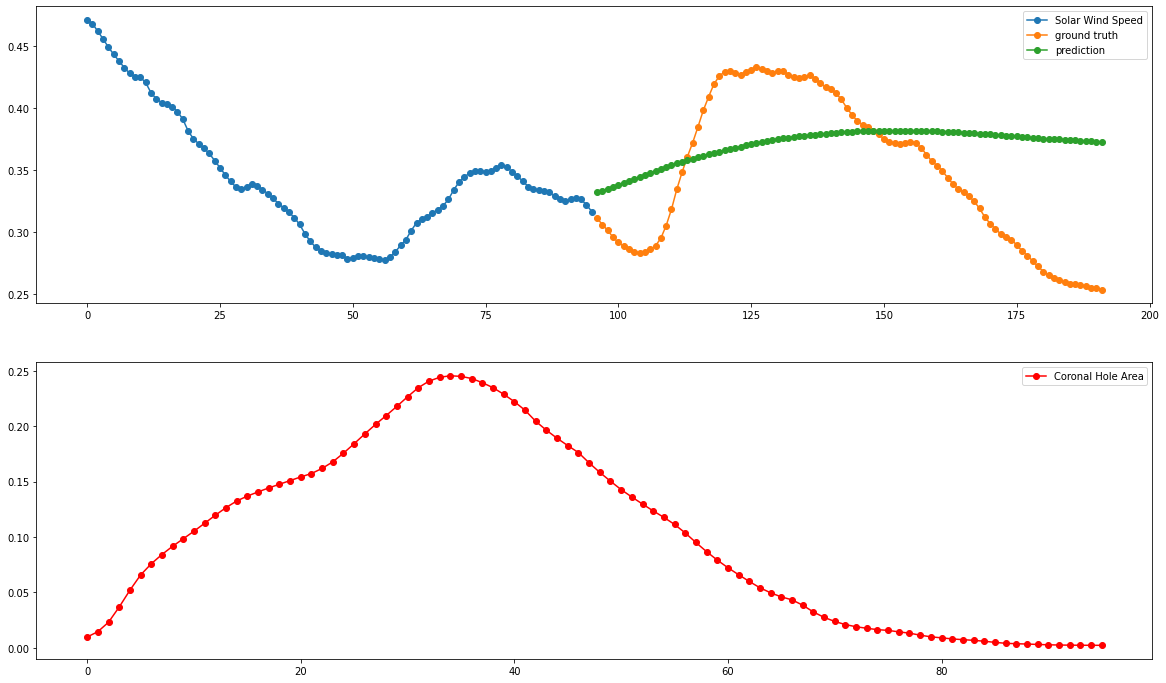

In [38]:
x_range = np.array(range(seq_len + seq_len_out))
idx = 48

plt.figure(figsize=(20, 12))

plt.subplot(2,1,1)
plt.plot(x_range[:seq_len], x_test[idx, :, 0], label='Solar Wind Speed', marker='o')

plt.legend()

plt.plot(x_range[seq_len:], y_test[idx], label='ground truth', marker='o')

series = x_test[idx:idx+1, ..., 0]
series_ch = x_test[idx:idx+1, ..., 1]
#series_la = x_test[idx:idx+1, ..., 2]

x_inp = np.stack((series, series_ch), -1)
#x_inp = np.stack((series, series_ch, series_la), -1)
series = model.predict(x_inp)[0]

plt.plot(x_range[seq_len:], series, label='prediction', marker='o')
plt.legend()

plt.subplot(2,1,2)
plt.plot(x_range[:seq_len], x_test[idx, :, 1], label='Coronal Hole Area', marker='o', color='red')
plt.legend()

In [42]:
pred_day = 96
ground_truth = y_test[:, pred_day - 1]
prediction = model.predict(x_test)[:, pred_day - 1]
x_range = time_test[:, pred_day - 1]

In [36]:
np.corrcoef(ground_truth,prediction)

array([[1.        , 0.42442953],
       [0.42442953, 1.        ]])

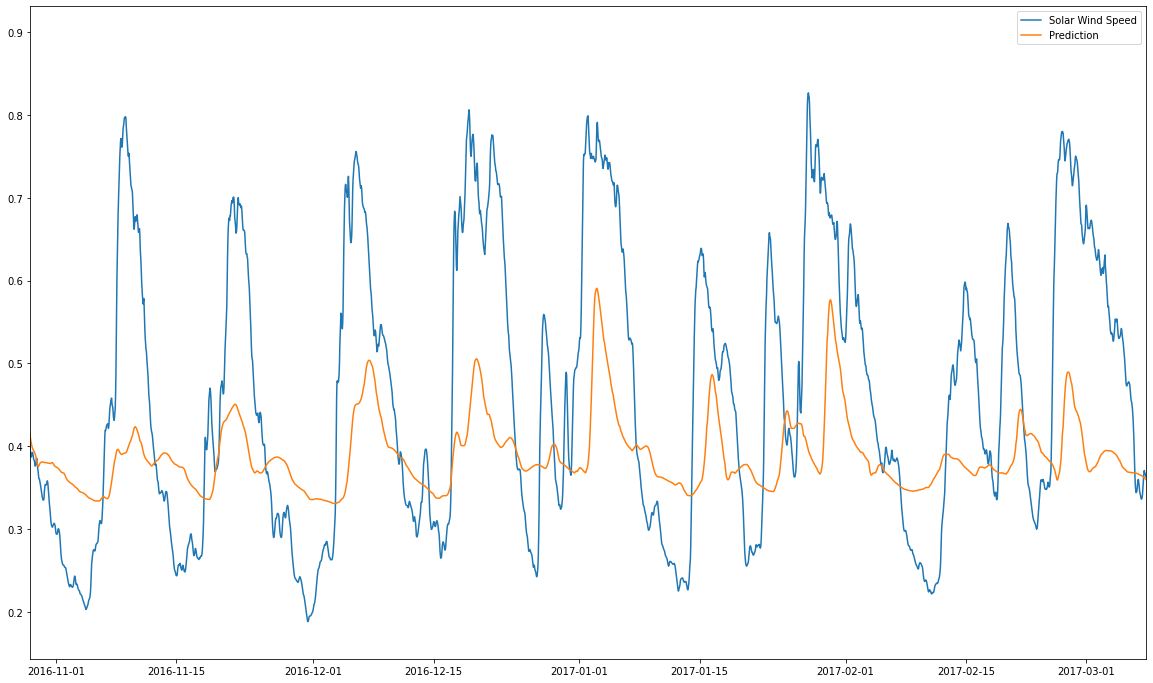

In [44]:
plt.figure(figsize=(20, 12))
plt.plot(x_range, ground_truth, label='Solar Wind Speed')
plt.plot(x_range, prediction, label='Prediction')
#plt.axvline(100 + pred_day, color='red')
#plt.axvline(100 + pred_day * 2, color='red')
#plt.axvline(100 + pred_day * 3, color='red')
#plt.axvline(100 + pred_day * 4, color='red')
plt.xlim(datetime(2016,10,29), datetime(2017,3,8))
plt.legend()